In [36]:
'''
한성대학교 컴퓨터공학부 빅데이터, 웹 공학 트랙
1971543_이찬우
2022-01 빅데이터프로그래밍 기말 프로젝트 과제
'사람 얼굴 이미지에서 감정 분석을 통한 감정 결과 도출'
'''
# 프로젝트에 필요한 라이브러리 셋팅
# Tensorflow / keras API 활용
from tensorflow.keras.utils import to_categorical  # 카테고리화
import random
import copy  # 복사 라이브러리
import pandas as pd
import numpy as np
import os
import PIL  # 이미지 처리 도움 라이브러리
import seaborn as sns  # 데이터 시각화
import pickle
from PIL import *
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.python.keras import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from keras import optimizers
import matplotlib.pyplot as plt
from matplotlib import rc, font_manager  # 한글 폰트 사용 가능하게 설정
from sklearn.model_selection import train_test_split

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # CPU AVX 연산 로그 강제 숨키기
rc('font', family="NanumGothic")  # 나눔고딕 사용

In [37]:
# 데이터 셋 로드
keyfacial_df = pd.read_csv('data/data.csv')
# 해당 데이터 셋에는 왼쪽 눈, 오른쪽 눈, 코, 윗입술, 아랫입술 등 15개의 인식 포인트가 있다.
print(keyfacial_df)
# 총 2140개의 이미지, 2140개의 데이터 포인트와 31개의 열이 있다.

print(keyfacial_df.info())
# 이미지를 제외하고 모든 데이터 타입은 float64로 되어있다.

print(keyfacial_df.isnull().sum())
# null 값 체크

# 람다 함수를 이용 데이터를 reshape 해준다. 처리가 편하기 위해 96*96 픽셀 형태로 바꿔준다.
# 처리할 때는 'Image' 열을 이용
keyfacial_df['Image'] = keyfacial_df['Image'].apply(
    lambda x: np.fromstring(x, dtype=int, sep=' ').reshape(96, 96))

# reshape 확인
print(keyfacial_df['Image'][0].shape)  # 0번째 행을 가져와 96 * 96 변경되었는지 확인

      left_eye_center_x  left_eye_center_y  right_eye_center_x  \
0             66.033564          39.002274           30.227008   
1             64.332936          34.970077           29.949277   
2             65.057053          34.909642           30.903789   
3             65.225739          37.261774           32.023096   
4             66.725301          39.621261           32.244810   
...                 ...                ...                 ...   
2135          67.180378          35.816373           33.239956   
2136          65.724490          36.301020           25.377551   
2137          68.430866          38.651975           28.895857   
2138          64.152180          30.691592           27.000898   
2139          66.683755          34.483429           30.784490   

      right_eye_center_y  left_eye_inner_corner_x  left_eye_inner_corner_y  \
0              36.421678                59.582075                39.647423   
1              33.448715                58.856170  

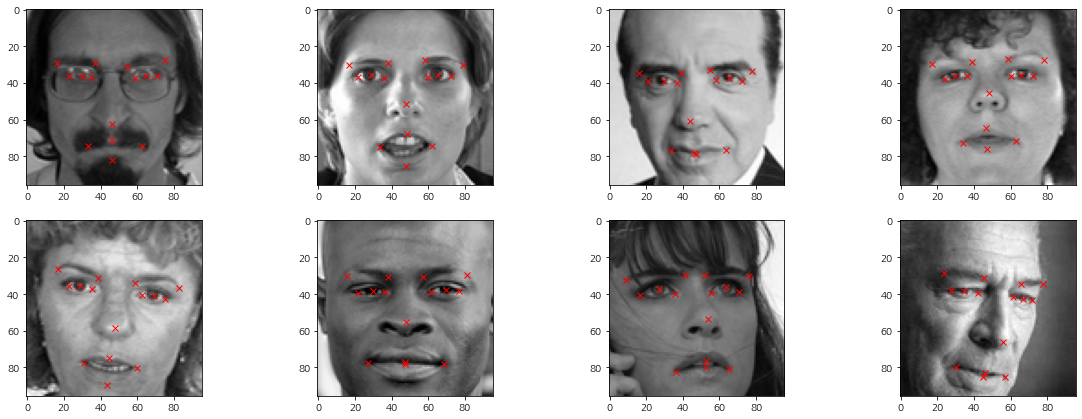

In [38]:
# 이미지 시각화 작업
# 3행 4열 총 12개의 랜덤 이미지 출력
fig = plt.figure(figsize=(20, 11))  # figure 사이즈 설정
for i in range(8):
    ax = fig.add_subplot(3, 4, i + 1)
    i = np.random.randint(1, len(keyfacial_df))
    plt.imshow(keyfacial_df['Image'][i], cmap='gray')  # 컬러는 회색으로 지정
    for j in range(1, 31, 2):
        plt.plot(keyfacial_df.loc[i][j-1],
                 keyfacial_df.loc[i][j], 'rx')  # 얼굴 이미지의 행 지정 후 필요한 정보 출력
        # 주요 얼굴 포인트 표시 후 시각화 출력

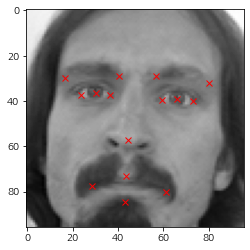

In [40]:
# 이미지 증강 작업
# 현재 가지고 있는 입력 데이터에 의존하지 않기 위해 추가적인 데이터 세트를 생성한다.
keyfacial_df_copy = copy.copy(keyfacial_df)

columns = keyfacial_df_copy.columns[:-1]  # 이미지를 제외한 모든 데이터 복사

# 이미지 증강 작업 - [1] 좌우 반전
keyfacial_df_copy['Image'] = keyfacial_df_copy['Image'].apply(  # 복사 한 후 keyfacial_df_copy의 'Image' 열에 저장
    lambda x: np.flip(x, axis=1))  # 람다 함수 적용해 x 입력 값에 실제 픽셀 값을 넣고 axis=1 을 이용해 y 축 뒤집기

# y축 값은 같으나 x축 값이 다르므로 x축 값만 선택 가능하게 반복문 작성
for i in range(len(columns)):
    if i % 2 == 0:
        keyfacial_df_copy[columns[i]] = keyfacial_df_copy[columns[i]].apply(
            lambda x: 96. - float(x))  # 데이터 포인트 뒤집기

# 좌우 반전 이미지 확인 (원본 이미지)
plt.imshow(keyfacial_df['Image'][0], cmap='gray')  # 0번째 행
for j in range(1, 31, 2):
    plt.plot(keyfacial_df.loc[0][j-1], keyfacial_df.loc[0][j], 'rx')

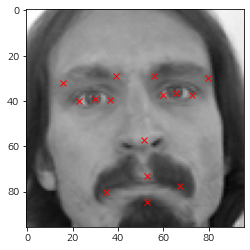

In [41]:
# 좌우 반전 이미지 확인 (변경된 이미지)
plt.imshow(keyfacial_df_copy['Image'][0], cmap='gray')  # 0번째 행
for j in range(1, 31, 2):
    plt.plot(keyfacial_df_copy.loc[0][j-1], keyfacial_df_copy.loc[0][j], 'rx')

(4280, 31)
(6420, 31)


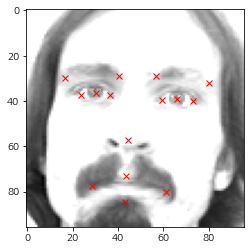

In [42]:
# 좌우 반전 데이터 프레임 생성
augmented_df = np.concatenate(
    (keyfacial_df, keyfacial_df_copy))  # concatenate 배열 연결

print(augmented_df.shape)  # 복사된 결과 확인 2140 + 2140 = 4280

# 이미지 증강 작업 - [2] 밝기 변경
# x의 픽셀 값을 가져온 후 픽셀 값을 곱한다. 곱하면 이미지의 밝기가 높아진다.
# 픽셀 범위는 0~255 사이로 해야한다.
keyfacial_df_copy = copy.copy(keyfacial_df)
keyfacial_df_copy['Image'] = keyfacial_df_copy['Image'].apply(
    lambda x: np.clip(random.uniform(1.5, 2) * x, 0.0, 255.0))  # 1.5부터 2 사이의 랜덤 숫자를 고르고 곱한다.
augmented_df = np.concatenate((augmented_df, keyfacial_df_copy))
print(augmented_df.shape)  # 복사된 결과 확인 2140 + 2140 + 2140 = 6420

# 이미지 밝기 증가 (확인)
plt.imshow(keyfacial_df_copy['Image'][0], cmap='gray')
for j in range(1, 31, 2):
    plt.plot(keyfacial_df_copy.loc[0][j-1], keyfacial_df_copy.loc[0][j], 'rx')

In [43]:
# 데이터 정규화 및 훈련 데이터 준비 수행
img = augmented_df[:, 30]  # 모든 이미지 가져오기
img = img/255.  # 가져온 다음 이미지 정규화 작업

# 비어있는 배열 생성 shape (x, 96, 96, 1)
X = np.empty((len(img), 96, 96, 1))

# 가지고 있는 모든 데이터 크기를 96*96로 확장 (배치 포맷 형태로)
for i in range(len(img)):
    X[i, ] = np.expand_dims(img[i], axis=2)

# array type을 float32로 변경
X = np.asarray(X).astype(np.float32)
print(X.shape)

# y 좌표 작업
y = augmented_df[:, :30]
y = np.asarray(y).astype(np.float32)
print(y.shape)

# 데이터를 학습 데이터와 테스트 데이터로 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# 20% 테스트 / 80% 학습

(6420, 96, 96, 1)
(6420, 30)


In [48]:
# 주요 얼굴 포인트 탐지를 위한 심층 잔차 신경망 구축
# 잔차 블럭 정의
def res_block(X, filter, stage):
    # Convolutional_block
    X_copy = X

    f1, f2, f3 = filter

    # Main Path
    # 합성 곱 이용
    X = Conv2D(f1, (1, 1), strides=(1, 1), name='res_'+str(stage) +
               '_conv_a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = MaxPool2D((2, 2))(X)
    X = BatchNormalization(axis=3, name='bn_'+str(stage)+'_conv_a')(X)
    X = Activation('relu')(X)

    X = Conv2D(f2, kernel_size=(3, 3), strides=(1, 1), padding='same', name='res_' +
               str(stage)+'_conv_b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_'+str(stage)+'_conv_b')(X)
    X = Activation('relu')(X)

    X = Conv2D(f3, kernel_size=(1, 1), strides=(1, 1), name='res_' +
               str(stage)+'_conv_c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_'+str(stage)+'_conv_c')(X)

    # Short path
    X_copy = Conv2D(f3, kernel_size=(1, 1), strides=(1, 1), name='res_' +
                    str(stage)+'_conv_copy', kernel_initializer=glorot_uniform(seed=0))(X_copy)
    X_copy = MaxPool2D((2, 2))(X_copy)
    X_copy = BatchNormalization(
        axis=3, name='bn_'+str(stage)+'_conv_copy')(X_copy)

    # ADD
    X = Add()([X, X_copy])
    X = Activation('relu')(X)

    # Identity Block 1
    X_copy = X

    # Main Path
    X = Conv2D(f1, (1, 1), strides=(1, 1), name='res_'+str(stage) +
               '_identity_1_a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_'+str(stage)+'_identity_1_a')(X)
    X = Activation('relu')(X)

    X = Conv2D(f2, kernel_size=(3, 3), strides=(1, 1), padding='same', name='res_' +
               str(stage)+'_identity_1_b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_'+str(stage)+'_identity_1_b')(X)
    X = Activation('relu')(X)

    X = Conv2D(f3, kernel_size=(1, 1), strides=(1, 1), name='res_'+str(stage) +
               '_identity_1_c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_'+str(stage)+'_identity_1_c')(X)
    # Short path에서는 그냥 Identity mapping만 하면 된다.

    # ADD (X, X_copy 합침)
    X = Add()([X, X_copy])
    X = Activation('relu')(X)

    # Identity Block 2
    X_copy = X

    # Main Path
    X = Conv2D(f1, (1, 1), strides=(1, 1), name='res_'+str(stage) +
               '_identity_2_a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_'+str(stage)+'_identity_2_a')(X)
    X = Activation('relu')(X)

    X = Conv2D(f2, kernel_size=(3, 3), strides=(1, 1), padding='same', name='res_' +
               str(stage)+'_identity_2_b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_'+str(stage)+'_identity_2_b')(X)
    X = Activation('relu')(X)

    X = Conv2D(f3, kernel_size=(1, 1), strides=(1, 1), name='res_'+str(stage) +
               '_identity_2_c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_'+str(stage)+'_identity_2_c')(X)

    # ADD
    X = Add()([X, X_copy])
    X = Activation('relu')(X)
    # 둘을 합한 다음 활성화 함수에 적용하면, 기본적으로 잔차 블록을 구축한다.

    return X

In [50]:
input_shape = (96, 96, 1)

# Input tensorflow shape
X_input = Input(input_shape)

# Zero-padding
X = ZeroPadding2D((3, 3))(X_input)

# 1 - stage
X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1',
           kernel_initializer=glorot_uniform(seed=0))(X)
X = BatchNormalization(axis=3, name='bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((3, 3), strides=(2, 2))(X)

# 2 - stage
X = res_block(X, filter=[64, 64, 256], stage=2)

# 3 - stage
X = res_block(X, filter=[128, 128, 512], stage=3)


# Average Pooling
X = AveragePooling2D((2, 2), name='Averagea_Pooling')(X)

# Final layer
# Dense 인공 신경망 구축
# 1. 특성 맵들을 펼친다.
X = Flatten()(X)
# 2. Dense()
X = Dense(4096, activation='relu')(X)
# 3. Dropout() -> 네트워크 일반화 성능에 도움을 준다.
X = Dropout(0.2)(X)  # 뉴런 20% 드롭아웃
# 4. Dense()
X = Dense(2048, activation='relu')(X)
# 5. Dropout()
X = Dropout(0.1)(X)  # 뉴런 10% 드롭아웃
# 6. Dense()
X = Dense(30, activation='relu')(X)

In [51]:
# 첫 번째 나만의 모델 생성
model_1_facialKeyPoints = Model(inputs=X_input, outputs=X)
model_1_facialKeyPoints.summary()  # 모델 요약본 출력

# 훈련된 주요 얼굴 포인트 감지 모델 성능 평가
with open('data/detection.json', 'r') as json_file:  # 모델 오픈 detection.json
    json_savedModel = json_file.read()

# 모델 인식
model_1_facialKeyPoints = tf.keras.models.model_from_json(json_savedModel)
model_1_facialKeyPoints.load_weights(
    'data/weights_keypoint.hdf5')  # 가중치 저장된 파일

# Adam 옵티마이저 사용 해당 프로젝트에 효과적으로 최적화를 할 수 있어 사용
# adam 옵티마이저 학습률 0.001 설정 후 모델 컴파일
adam = tf.keras.optimizers.Adam(
    learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model_1_facialKeyPoints.compile(
    loss="mean_squared_error", optimizer=adam, metrics=['accuracy'])

# 모델 평가
result = model_1_facialKeyPoints.evaluate(X_test, y_test)
print("모델 정확도 : {}".format(result[1]))

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Total params: 18,016,286
Trainable params: 18,007,710
Non-trainable params: 8,576
__________________________________________________________________________________________________
41/41 [==============================] - 1s 19ms/step - loss: 7.1675 - accuracy: 0.8279
모델 정확도 : 0.8278816342353821


In [52]:
# 얼굴 표정 감지
'''
0 = 화남
1 = 혐오
2 = 슬픔
3 = 행복
4 = 놀람
'''

# 표정 데이터에 대한 csv 파일 읽기
facialexpression_df = pd.read_csv('data/icml_face_data.csv')
print(facialexpression_df)  # 48 * 48 픽셀 이미지 데이터

       emotion                                             pixels
0            0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1            0  151 150 147 155 148 133 111 140 170 174 182 15...
2            2  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
3            2  20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...
4            3  77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...
...        ...                                                ...
24563        3  0 39 81 80 104 97 51 64 68 46 41 67 53 68 70 5...
24564        0  181 177 176 156 178 144 136 132 122 107 131 16...
24565        3  178 174 172 173 181 188 191 194 196 199 200 20...
24566        0  17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...
24567        3  30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...

[24568 rows x 2 columns]


In [53]:
# 문자열 형식의 픽셀 값을 배열 형식으로 변환하는 함수
def string2array(x):
    return np.array(x.split(' ')).reshape(48, 48, 1).astype('float32')


# Resize image (48, 48) -> (96, 96)
def resize(x):

    img = x.reshape(48, 48)
    return cv2.resize(img, dsize=(96, 96), interpolation=cv2.INTER_CUBIC)
    # 추후 하나의 이미지를 두 모델에 학습 시키고 예측을 만들 예정


# 데이터를 가져와 string2array() 실행 -> array 형태로 바뀜
# csv 데이터 pixels 앞에 공백이 있어 한 칸 띄었음
facialexpression_df[' pixels'] = facialexpression_df[' pixels'].apply(
    lambda x: string2array(x))

# resize
facialexpression_df[' pixels'] = facialexpression_df[' pixels'].apply(
    lambda x: resize(x))

# facialexpression_df 확인
print(facialexpression_df.head())

# data_frame의 모양 확인
print(facialexpression_df.shape)  # 24568행, 2열

# 데이터 프레임에 null 값이 있는지 확인
print(facialexpression_df.isnull().sum())

# 감정 분석 후 결과를 위한 라벨링 작업
label_to_text = {0: '화남', 1: '혐오', 2: '슬픔', 3: '행복', 4: '놀람'}

# 이미지 시각화 및 레이블 표시
emotions = [0, 1, 2, 3, 4]

   emotion                                             pixels
0        0  [[69.316925, 73.03865, 79.13719, 84.17186, 85....
1        0  [[151.09435, 150.91393, 150.65791, 148.96367, ...
2        2  [[23.061905, 25.50914, 29.47847, 33.99843, 36....
3        2  [[20.083221, 19.079437, 17.398712, 17.158691, ...
4        3  [[76.26172, 76.54747, 77.001785, 77.7672, 78.4...
(24568, 2)
emotion    0
 pixels    0
dtype: int64


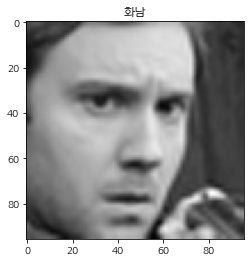

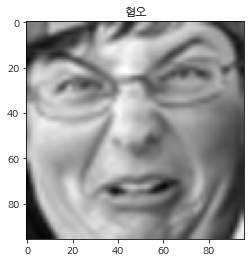

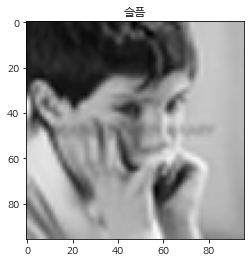

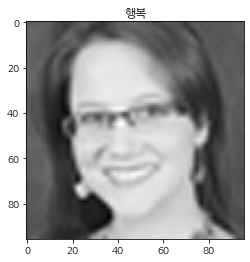

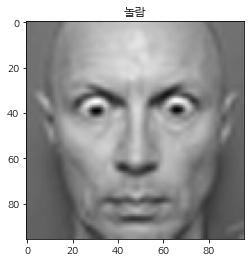

In [54]:
# 각 감정마다 하나씩 분석 결과 출력
for i in emotions:
    data = facialexpression_df[facialexpression_df['emotion'] == i][:1]
    img = data[' pixels'].item()
    img = img.reshape(96, 96)  # 이미지 사이즈 96 * 96 지정
    plt.figure()
    plt.title(label_to_text[i])
    plt.imshow(img, cmap='gray')  # 회색 지정

In [55]:
# 데이터 준비 및 이미지 증강 작업 수행
# 데이터 프레임을 기능과 레이블로 분할
X = facialexpression_df[' pixels']  # 입력 데이터 X
y = to_categorical(facialexpression_df['emotion'])  # 출력 데이터 y

# 각각의 정보 확인
print(X[0])

# 각각의 이미지 한 장당 하나의 감정만 가지고 있음.
print(y)

X = np.stack(X, axis=0)
X = X.reshape(24568, 96, 96, 1)

print(X.shape, y.shape)


# 데이터 프레임을 학습, 테스트 및 검증 데이터 프레임으로 분할
# 90%를 학습에 10%를 테스트에 쓰도록 설정
# 그다음으로 해 볼 것은 테스팅 데이터를 가지고와서 (X_test, y_test) 반절로 나눈다.
# 그래서 test_size를 0.5로 설정한다. 즉, 테스팅 데이터를 가지고 와서 X 테스트와 X 검증에 한번 더 나누어 주는 것이죠
X_train, X_Test, y_train, y_Test = train_test_split(
    X, y, test_size=0.1, shuffle=True)
X_val, X_Test, y_val, y_Test = train_test_split(
    X_Test, y_Test, test_size=0.5, shuffle=True)

# 이미지 전처리
X_train = X_train/255
X_val = X_val / 255
X_Test = X_Test/255

# 이미지 증강 자동으로 처리 (ImageDataGenerator) 사용
# 사용법 : https://keras.io/api/preprocessing/image/
train_datagen = ImageDataGenerator(
    # 좌우반전 크기 등 하나의 함수로 해결
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,  # 상하반전
    brightness_range=[1.1, 1.5],  # 밝기
    fill_mode="nearest")

[[ 69.316925  73.03865   79.13719  ...  40.73619   40.6584    40.5394  ]
 [ 68.66325   70.95224   74.71768  ...  43.274765  42.037186  41.223618]
 [ 67.768814  67.71646   67.67172  ...  47.39473   44.26329   42.31465 ]
 ...
 [ 74.89021   76.79553   79.90259  ...  71.463425  59.32875   51.74736 ]
 [ 76.68126   75.808105  74.25452  ...  93.943375  79.77934   71.13246 ]
 [ 77.63858   75.15074   70.8846   ... 107.66351   92.23212   82.91585 ]]
[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 ...
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]]
(24568, 96, 96, 1) (24568, 5)


In [56]:
# 얼굴 표정 분류를 위한 딥 러닝 모델 구축 및 훈련

# 모델2의 입력 shape는 모델1과 같아야한다.
input_shape = (96, 96, 1)

# Input tensor shape
X_input = Input(input_shape)

# Zero-padding
X = ZeroPadding2D((3, 3))(X_input)

# 1단계
X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1',
           kernel_initializer=glorot_uniform(seed=0))(X)
X = BatchNormalization(axis=3, name='bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((3, 3), strides=(2, 2))(X)

# 2단계 - 위에서 사용했던 res-block 이용
X = res_block(X, filter=[64, 64, 256], stage=2)  # 필터사이즈 [64, 64, 256]

# 3단계
X = res_block(X, filter=[128, 128, 512], stage=3)  # 필터사이즈 [128, 128, 512]

# Average Pooling
X = AveragePooling2D((4, 4), name='Averagea_Pooling')(X)

# 마지막 레이어
X = Flatten()(X)
# 5가지의 감정 인공신경망
X = Dense(5, activation='softmax', name='Dense_final',
          kernel_initializer=glorot_uniform(seed=0))(X)

model_2_emotion = Model(inputs=X_input, outputs=X,
                        name='Resnet18')  # Resnet18 이용

model_2_emotion.summary()

Model: "Resnet18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Total params: 1,174,021
Trainable params: 1,165,445
Non-trainable params: 8,576
__________________________________________________________________________________________________


In [57]:
# 네트워크 훈련
model_2_emotion.compile(
    # 2개 이상의 카테고리가 있으므로 이렇게 설정
    optimizer="Adam", loss="categorical_crossentropy", metrics=["accuracy"])

'''
데이터를 학습, 테스트, 검증으로 나누었기 때문에 모델 학습을 수행할 시
검증 데이터세트를 이용한다.
검증 loss를 지켜보고 모델이 학습될 때 학습 데이터세트의 loss가 줄어들면 검증 loss도
줄어들게 해주는 작업을 수행해야 한다.
'''
earlystopping = EarlyStopping(
    monitor='val_loss', mode='min', verbose=1, patience=20)

# 검증 loss가 적은 최상의 모델을 저장.
checkpointer = ModelCheckpoint(
    filepath="data/FacialExpression_weights.hdf5", verbose=1, save_best_only=True)

# 훈련된 얼굴 표정 분류기 모델의 성능 평가
with open('data/emotion.json', 'r') as json_file:
    json_savedModel = json_file.read()  # 모델 구조

# load the model architecture
model_2_emotion = tf.keras.models.model_from_json(json_savedModel)
model_2_emotion.load_weights('data/weights_emotions.hdf5')  # 학습된 가중치들 로드
model_2_emotion.compile(
    optimizer="Adam", loss="categorical_crossentropy", metrics=["accuracy"])

# 테스트 정확도 확인
score = model_2_emotion.evaluate(X_Test, y_Test)
print('Test 정확도: {}'.format(score[1]))

39/39 [==============================] - 2s 23ms/step - loss: 0.3678 - accuracy: 0.8682
Test 정확도: 0.8681855201721191


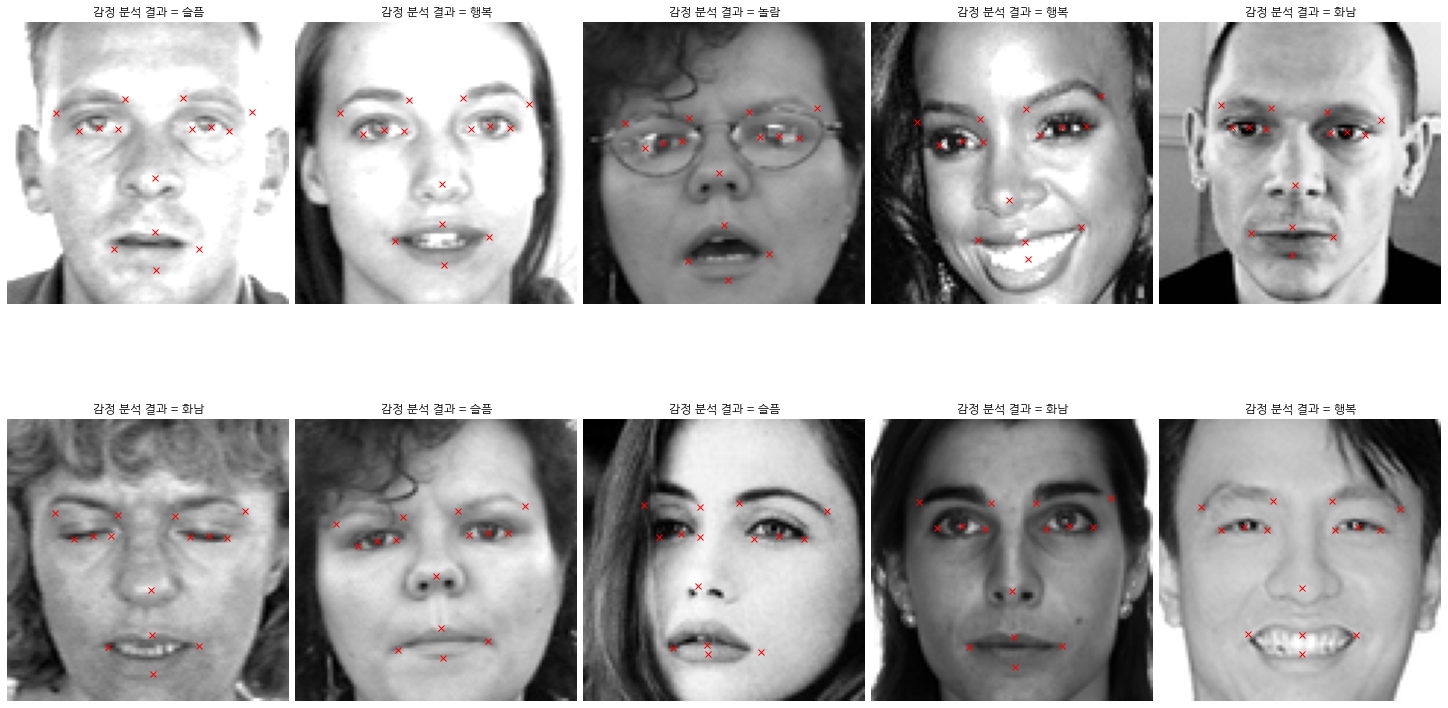

In [58]:
# [최종]
# 두 모델 결합 (1) 얼굴 포인트 감지 (2) 얼굴 감정 인식
# 랜덤으로 25개의 이미지로 구성된 그리드를 예측된 감정과 얼굴 포인트 시각화 출력!
def predict(X_test):

    # 키포인트 모델에서 예측하기
    df_predict = model_1_facialKeyPoints.predict(X_test)

    # 감정 모델에서 예측하기
    df_emotion = np.argmax(model_2_emotion.predict(X_test), axis=-1)

    # (856,)에서 (856,1)로 배열 재구성
    df_emotion = np.expand_dims(df_emotion, axis=1)

    # 예측을 데이터 프레임으로 변환
    df_predict = pd.DataFrame(df_predict, columns=columns)

    # 예측된 데이터 프레임에 감정 추가
    df_predict['emotion'] = df_emotion

    return df_predict


df_predict = predict(X_test)  # df_predict 선언

fig, axes = plt.subplots(2, 5, constrained_layout=True, figsize=(20, 11))
axes = axes.ravel()
for i in range(10):
    axes[i].imshow(X_test[i].squeeze(), cmap='gray')
    axes[i].set_title('감정 분석 결과 = {}'.format(
        label_to_text[df_predict['emotion'][i]]))
    axes[i].axis('off')
    for j in range(1, 31, 2):
        axes[i].plot(df_predict.loc[i][j-1], df_predict.loc[i][j], 'rx')
